Cleaning Robots Multi-Agent Simulation

--- Experiment 1: Varying Number of Agents ---
Finished simulation with 1 agents → {'Agents': 1, 'Time to Clean': 200, 'Clean Percentage': 84.0, 'Total Movements': 186, 'Finished Cleaning': False}
Finished simulation with 2 agents → {'Agents': 2, 'Time to Clean': 200, 'Clean Percentage': 94.0, 'Total Movements': 376, 'Finished Cleaning': False}
Finished simulation with 3 agents → {'Agents': 3, 'Time to Clean': 178, 'Clean Percentage': 100.0, 'Total Movements': 504, 'Finished Cleaning': True}
Finished simulation with 5 agents → {'Agents': 5, 'Time to Clean': 148, 'Clean Percentage': 100.0, 'Total Movements': 710, 'Finished Cleaning': True}
Finished simulation with 8 agents → {'Agents': 8, 'Time to Clean': 93, 'Clean Percentage': 100.0, 'Total Movements': 714, 'Finished Cleaning': True}


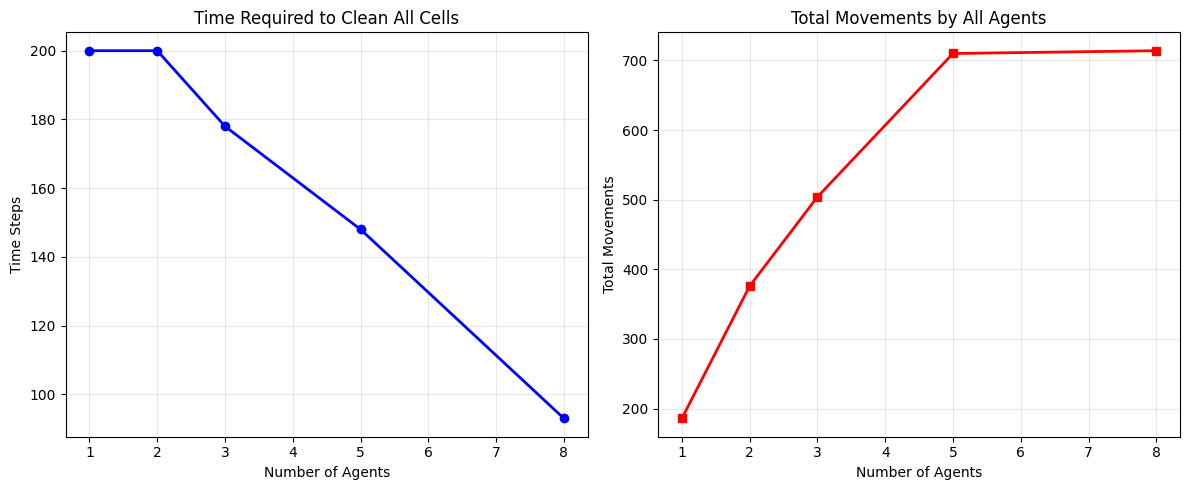


--- Experiment 2: Varying Dirty Percentage ---
Finished simulation with 10% dirty → {'Agents': 5, 'Time to Clean': 188, 'Clean Percentage': 100.0, 'Total Movements': 930, 'Finished Cleaning': True}
Finished simulation with 20% dirty → {'Agents': 5, 'Time to Clean': 157, 'Clean Percentage': 100.0, 'Total Movements': 765, 'Finished Cleaning': True}
Finished simulation with 30% dirty → {'Agents': 5, 'Time to Clean': 161, 'Clean Percentage': 100.0, 'Total Movements': 775, 'Finished Cleaning': True}
Finished simulation with 40% dirty → {'Agents': 5, 'Time to Clean': 99, 'Clean Percentage': 100.0, 'Total Movements': 455, 'Finished Cleaning': True}
Finished simulation with 50% dirty → {'Agents': 5, 'Time to Clean': 150, 'Clean Percentage': 100.0, 'Total Movements': 700, 'Finished Cleaning': True}
Finished simulation with 60% dirty → {'Agents': 5, 'Time to Clean': 276, 'Clean Percentage': 100.0, 'Total Movements': 1320, 'Finished Cleaning': True}
Finished simulation with 70% dirty → {'Agents'

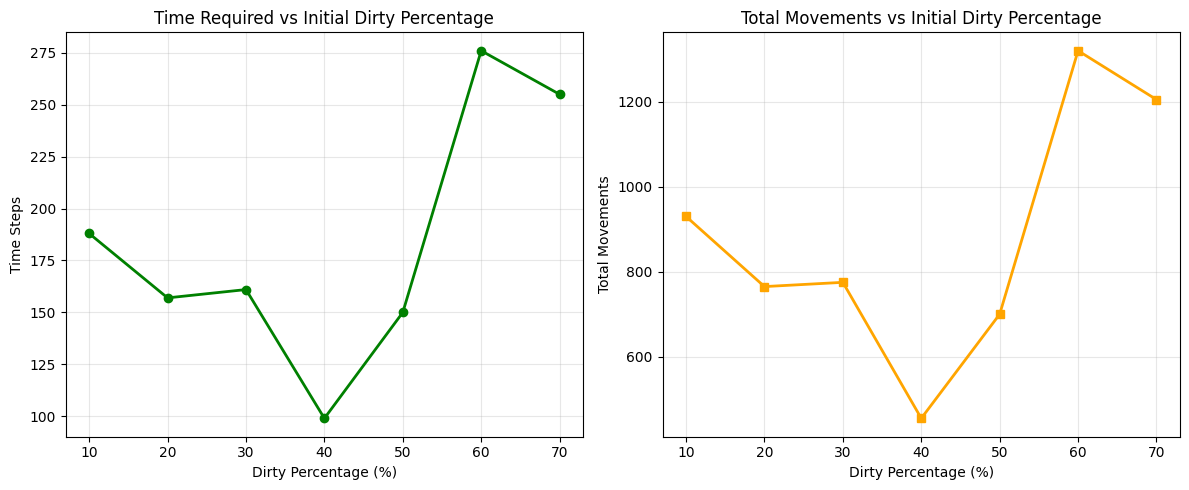


All experiments completed!


In [4]:
"""
Cleaning Robots Multi-Agent Simulation
Integrantes: E. Aislinn Gil Orozco - A01666225
             Bastian Uribe Sánchez - A01666949
"""

import random
from enum import Enum
import matplotlib.pyplot as plt
import mesa


class CellState(Enum):
    CLEAN = 0
    DIRTY = 1


class CleaningRobot(mesa.Agent):

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.movements = 0

    def step(self):
        cell_state = self.model.get_cell_state(self.pos)

        if cell_state == CellState.DIRTY:
            self.model.clean_cell(self.pos)
        else:
            self.move_randomly()

    def move_randomly(self):
        possible_moves = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )

        if possible_moves:
            new_position = self.random.choice(possible_moves)
            self.model.grid.move_agent(self, new_position)
            self.movements += 1


class CleaningRobotModel(mesa.Model):


    def __init__(self, width, height, n_agents, dirty_percentage, max_time):
        super().__init__()
        self.width = width
        self.height = height
        self.n_agents = n_agents
        self.dirty_percentage = dirty_percentage
        self.max_time = max_time
        self.current_step = 0
        self.time_to_clean = None
        self.running = True

        self.schedule = mesa.time.RandomActivation(self)

        self.grid = mesa.space.MultiGrid(width, height, torus=False)

        self.cells_state = {(x, y): CellState.CLEAN for x in range(width) for y in range(height)}

        total_cells = width * height
        n_dirty_cells = int(total_cells * dirty_percentage / 100)
        dirty_positions = self.random.sample(list(self.cells_state.keys()), n_dirty_cells)
        for pos in dirty_positions:
            self.cells_state[pos] = CellState.DIRTY

        # create agents and place them at (1, 1) as specified in requirements
        for i in range(n_agents):
            agent = CleaningRobot(i, self)
            self.schedule.add(agent)
            self.grid.place_agent(agent, (1, 1))

        # data collector
        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Clean Percentage": self.get_clean_percentage,
                "Total Movements": self.get_total_movements,
                "All Clean": self.is_all_clean,
            }
        )

    def get_cell_state(self, pos):
        return self.cells_state.get(pos, CellState.CLEAN)

    def clean_cell(self, pos):
        if self.cells_state.get(pos) == CellState.DIRTY:
            self.cells_state[pos] = CellState.CLEAN

    def is_all_clean(self):
        return all(state == CellState.CLEAN for state in self.cells_state.values())

    def get_clean_percentage(self):
        total = len(self.cells_state)
        clean = sum(1 for state in self.cells_state.values() if state == CellState.CLEAN)
        return (clean / total) * 100

    def get_total_movements(self):
        return sum(agent.movements for agent in self.schedule.agents)

    def step(self):
        self.current_step += 1
        self.datacollector.collect(self)
        self.schedule.step()

        if self.time_to_clean is None and self.is_all_clean():
            self.time_to_clean = self.current_step
            self.running = False

        if self.current_step >= self.max_time:
            self.running = False

    def run_model(self):
        while self.running and self.current_step < self.max_time:
            self.step()

        self.datacollector.collect(self)
        return {
            "Agents": self.n_agents,
            "Time to Clean": self.time_to_clean if self.time_to_clean else self.max_time,
            "Clean Percentage": self.get_clean_percentage(),
            "Total Movements": self.get_total_movements(),
            "Finished Cleaning": self.is_all_clean(),
        }


def experiment_varying_agents():
    """Runs simulations with different agent counts and plots results."""
    width, height = 10, 10
    dirty_percentage = 30
    max_time = 200
    agent_counts = [1, 2, 3, 5, 8]

    results = []
    for n in agent_counts:
        model = CleaningRobotModel(width, height, n, dirty_percentage, max_time)
        summary = model.run_model()
        results.append(summary)
        print(f"Finished simulation with {n} agents → {summary}")

    # plot results
    times = [r["Time to Clean"] for r in results]
    moves = [r["Total Movements"] for r in results]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(agent_counts, times, marker="o", color="blue", linewidth=2)
    plt.xlabel("Number of Agents")
    plt.ylabel("Time Steps")
    plt.title("Time Required to Clean All Cells")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(agent_counts, moves, marker="s", color="red", linewidth=2)
    plt.xlabel("Number of Agents")
    plt.ylabel("Total Movements")
    plt.title("Total Movements by All Agents")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return results


def experiment_varying_dirty_percentage():
    """Runs simulations with different dirty percentages."""
    width, height = 10, 10
    n_agents = 5
    max_time = 300
    dirty_percentages = [10, 20, 30, 40, 50, 60, 70]

    results = []
    for dirty_pct in dirty_percentages:
        model = CleaningRobotModel(width, height, n_agents, dirty_pct, max_time)
        summary = model.run_model()
        results.append(summary)
        print(f"Finished simulation with {dirty_pct}% dirty → {summary}")

    times = [r["Time to Clean"] for r in results]
    moves = [r["Total Movements"] for r in results]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(dirty_percentages, times, marker="o", color="green", linewidth=2)
    plt.xlabel("Dirty Percentage (%)")
    plt.ylabel("Time Steps")
    plt.title("Time Required vs Initial Dirty Percentage")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(dirty_percentages, moves, marker="s", color="orange", linewidth=2)
    plt.xlabel("Dirty Percentage (%)")
    plt.ylabel("Total Movements")
    plt.title("Total Movements vs Initial Dirty Percentage")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return results


if __name__ == "__main__":
    print("Cleaning Robots Multi-Agent Simulation")
    print("=" * 60)

    print("\n--- Experiment 1: Varying Number of Agents ---")
    results_agents = experiment_varying_agents()

    print("\n--- Experiment 2: Varying Dirty Percentage ---")
    results_dirty = experiment_varying_dirty_percentage()

 